In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [4]:
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1)

In [5]:
df = pd.merge(df, pd.get_dummies(df['zip_code']), left_index=True, right_index=True)

In [6]:
df = pd.merge(df, pd.get_dummies(df['channel']), left_index=True, right_index=True)

In [7]:
df.drop(columns=['zip_code', 'channel'], inplace=True)

In [42]:
df.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Rural,Surburban,Urban,Multichannel,Phone,Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1


In [25]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
            'Multichannel', 'Phone', 'Web', 'Rural', 'Surburban', 'Urban']
target = 'target'
treat = 'treatment'

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df[features],
                                                    df[target],
                                                    df[treat],
                                                    test_size=0.3,
                                                    stratify=df[target],
                                                    random_state=42)

### Одна модель с признаком коммуникации (S learner)

uplift@10%: 0.1012
uplift@20%: 0.0743


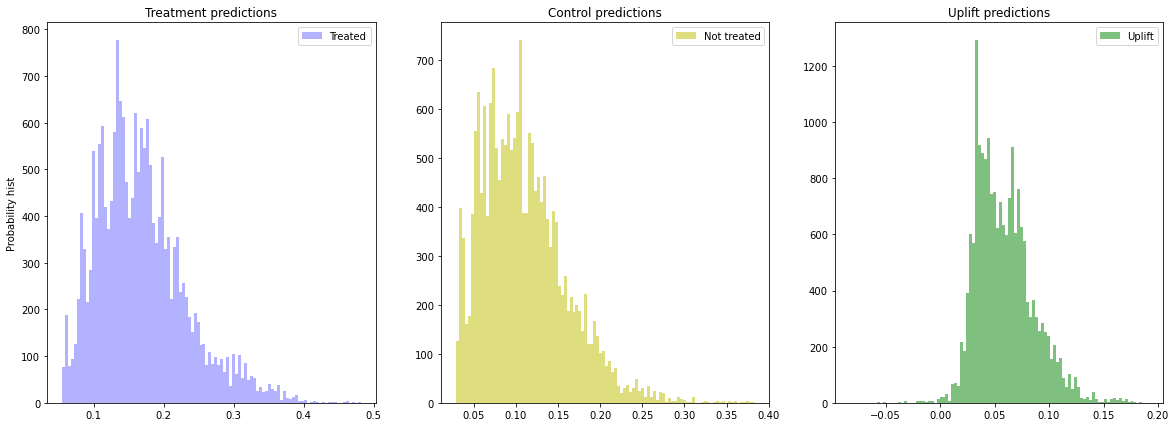

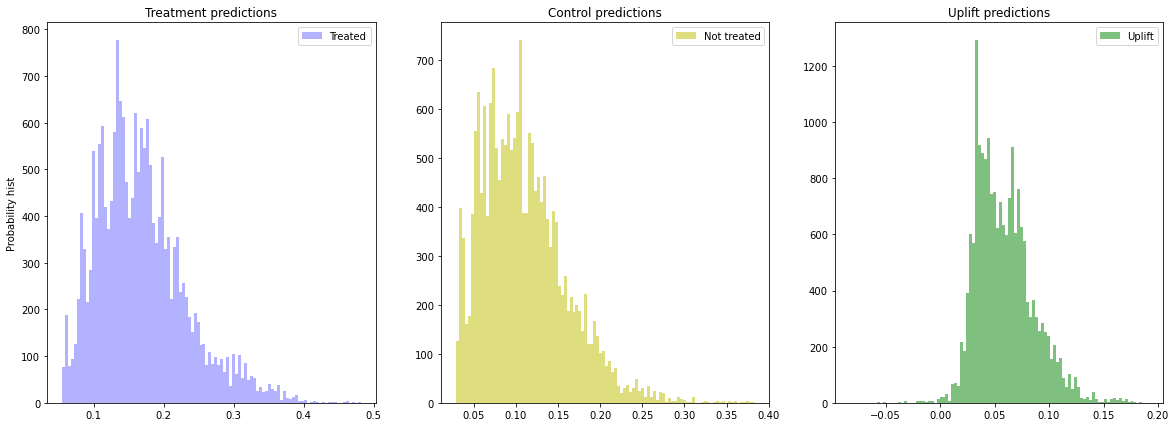

In [35]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

cat_features = ['recency', 'used_discount', 'used_bogo', 'is_referral', 'Multichannel', 'Phone',
                'Web', 'Rural', 'Surburban', 'Urban']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

models_results['approach'].append('SoloModel')

k = [0.1, 0.2]

for el in k:
    
    sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
    sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

    uplift_sm = sm.predict(X_test)

    sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=el)
    
    if el == 0.1:
        print(f'uplift@10%: {sm_score:.4f}')
        models_results['uplift@10%'].append(sm_score)
    elif el == 0.2:
        print(f'uplift@20%: {sm_score:.4f}')
        models_results['uplift@20%'].append(sm_score)

    # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
    sm_trmnt_preds = sm.trmnt_preds_
    # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
    sm_ctrl_preds = sm.ctrl_preds_

    # Отрисуем распределения вероятностей и их разность (uplift)
    plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [36]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.10124680491640226],
 'uplift@20%': [0.07427654946954543]}

### Трансформация классов

In [37]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

models_results['approach'].append('ClassTransformation')

for el in k:

    ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=el)
    
    if el == 0.1:
        print(f'uplift@10%: {ct_score:.4f}')
        models_results['uplift@10%'].append(ct_score)
    elif el == 0.2:
        print(f'uplift@20%: {ct_score:.4f}')
        models_results['uplift@20%'].append(ct_score)

uplift@10%: 0.0848
uplift@20%: 0.0788


### Две независимые модели

uplift@10%: 0.0811
uplift@20%: 0.0802


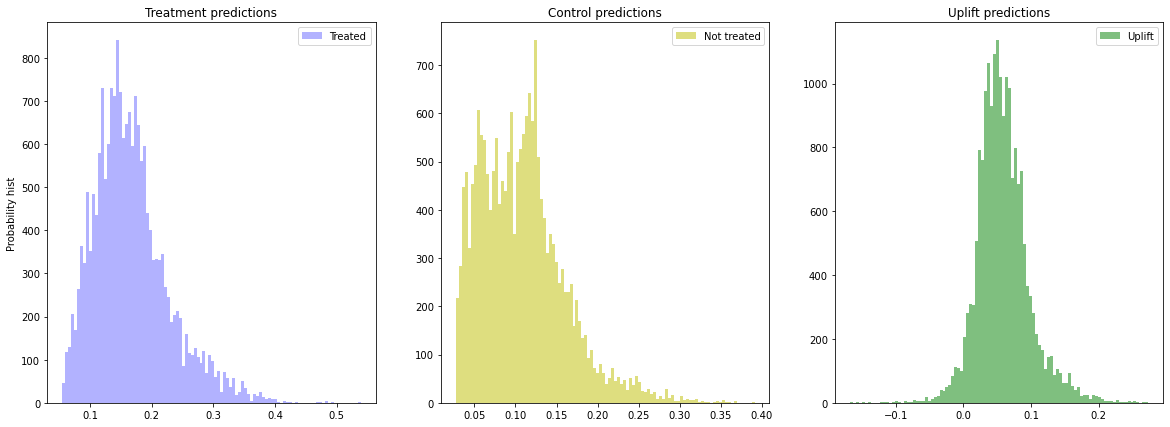

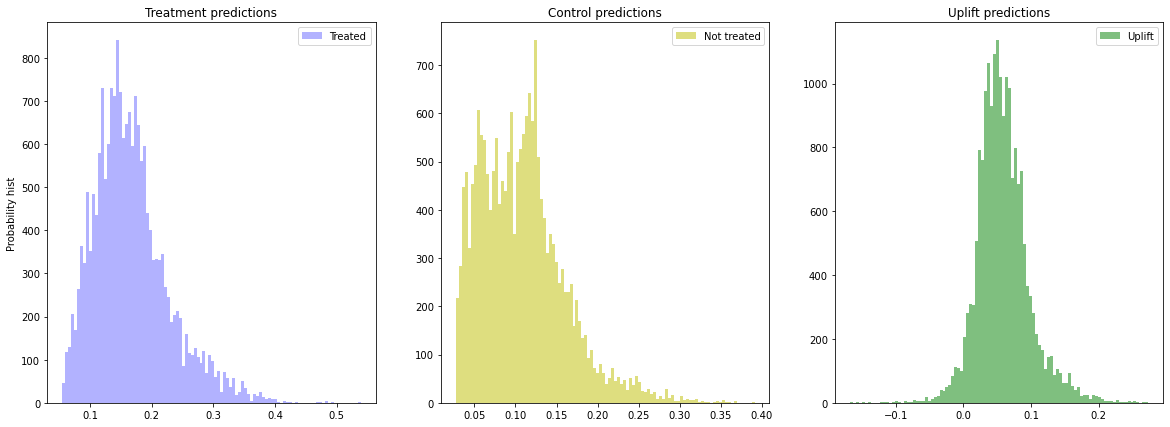

In [39]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

models_results['approach'].append('TwoModels')

for el in k:
    
    tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=el)
    
    if el == 0.1:
        print(f'uplift@10%: {tm_score:.4f}')
        models_results['uplift@10%'].append(tm_score)
    elif el == 0.2:
        print(f'uplift@20%: {tm_score:.4f}')
        models_results['uplift@20%'].append(tm_score)
    
    plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [40]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.101247,0.074277
1,ClassTransformation,0.084789,0.078848
2,TwoModels,0.081109,0.080238
